In [1]:
import json
import os
import sys
import warnings
import pickle as pkl
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings("ignore")

In [2]:
from AIPT.Benchmarks.OAS_dataset import OAS_data_loader
from AIPT.Models.Wollacott2019 import Bi_LSTM
from AIPT.Utils.model import Model
from AIPT.Utils import loader

In [3]:
def collate_fn(batch):
    """
    Retrieve the labels for training 
    """
    return batch, [x for seq in batch for x in seq] 

# Parameters

In [4]:
para_dict = {'epoch': 4,
             'step_size': 10,
             'batch_size': 8192,
             'learning_rate': 0.01,
             'gapped': True,
             'embedding_dim': 64,
             'hidden_dim': 64,
             'fixed_len': False}
datapath = '../../Benchmarks/OAS_dataset/data/'

# Data Loader

In [5]:
# Training data
data = pkl.load(open(os.path.join(datapath,'Human_train_seq_full_length.csv.gz'), 'rb'))
train_x = OAS_data_loader.encode_index(data=data['seq'].values, gapped=True)
train_loader = torch.utils.data.DataLoader(train_x, collate_fn=OAS_data_loader.collate_fn)

In [17]:
# Human test data
test_data = pkl.load(open(os.path.join(datapath,'Human_test_seq_full_length.csv.gz'), 'rb'))
test_x = OAS_data_loader.encode_index(data=test_data['seq'].values)
human_test_loader = torch.utils.data.DataLoader(test_x, collate_fn=collate_fn)

# Rabbit test data
test_data = pkl.load(open(os.path.join(datapath,'Rabbit_test_seq_full_length.csv.gz'), 'rb'))
test_x = OAS_data_loader.encode_index(data=test_data['seq'].values)
rabbit_test_loader = torch.utils.data.DataLoader(test_x, collate_fn=collate_fn)

# Mouse test data
test_data = pkl.load(open(os.path.join(datapath,'Mouse_test_seq_full_length.csv.gz'), 'rb'))
test_x = OAS_data_loader.encode_index(data=test_data['seq'].values)
mouse_test_loader = torch.utils.data.DataLoader(test_x, collate_fn=collate_fn)

# Rhesus test data
test_data = pkl.load(open(os.path.join(datapath,'Rhesus_test_seq_full_length.csv.gz'), 'rb'))
test_x = OAS_data_loader.encode_index(data=test_data['seq'].values)
rhesus_test_loader = torch.utils.data.DataLoader(test_x, collate_fn=collate_fn)

# Train & Test

In [10]:
model = Bi_LSTM.LSTM_Bi(para_dict)
model.fit(train_loader)
output_human_train = model.predict(train_loader)

# ROC curve

AUC score for mouse:  0.993064
AUC score for rabbit  1.0
AUC score for rhesus  0.986144


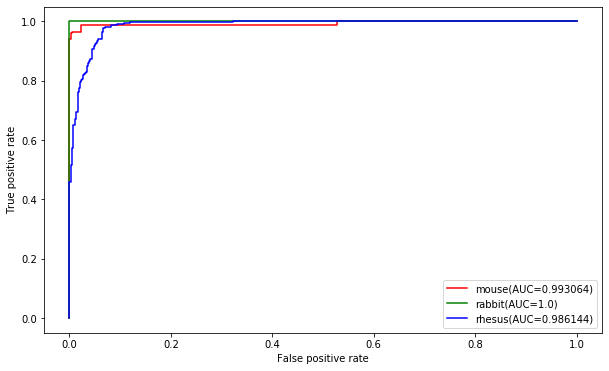

In [18]:
output_human = model.predict(human_test_loader)
plt.figure(figsize=(10,6))

# Mouse species roc curve
output_mouse = model.predict(mouse_test_loader)
label = [-1 if a < 1000 else 1 for a in range(2000)]
output = np.concatenate((output_human, output_mouse), axis=0)
mouse_fpr, mouse_tpr, _ = roc_curve(np.array(label), np.array(output))
AUC_score_mouse = roc_auc_score(np.array(label), np.array(output))
print('AUC score for mouse: ', AUC_score_mouse)
plt.plot(mouse_fpr, mouse_tpr, 'r', label='mouse(AUC=' + str(AUC_score_mouse) + ')')

# Rabbit species roc curve
output_rabbit = model.predict(rabbit_test_loader)
label = [-1 if a < 1000 else 1 for a in range(2000)]
output = np.concatenate((output_human, output_rabbit), axis=0)
rabbit_fpr, rabbit_tpr, _ = roc_curve(np.array(label), np.array(output))
AUC_score_rabbit = roc_auc_score(np.array(label), np.array(output))
print('AUC score for rabbit ', AUC_score_rabbit)
plt.plot(rabbit_fpr, rabbit_tpr, 'g', label='rabbit(AUC=' + str(AUC_score_rabbit) + ')')

# Rhesus species roc curve
output_rhesus = model.predict(rhesus_test_loader)
label = [-1 if a < 1000 else 1 for a in range(2000)]
output = np.concatenate((output_human, output_rhesus), axis=0)
rhesus_fpr, rhesus_tpr, _ = roc_curve(np.array(label), np.array(output))
AUC_score_rhesus = roc_auc_score(np.array(label), np.array(output))
print('AUC score for rhesus ', AUC_score_rhesus)
plt.plot(rhesus_fpr, rhesus_tpr, 'b', label='rhesus(AUC=' + str(AUC_score_rhesus) + ')')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()

Check out Figure 2(b) for the comparison

# Histogram plot

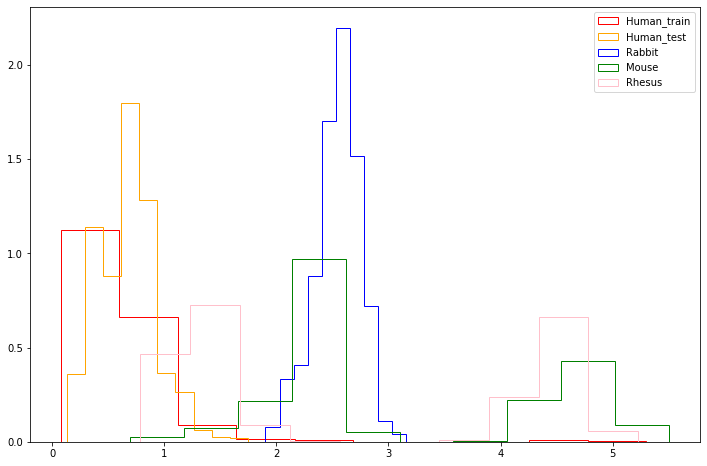

In [19]:
# Score Distribution

plt.figure(figsize=(12,8))
plt.hist(output_human_train, histtype='step', normed=True, color='red', label='Human_train')
plt.hist(output_human, histtype='step', normed=True, color='orange', label='Human_test')
plt.hist(output_rabbit, histtype='step', normed=True, color='blue', label='Rabbit')
plt.hist(output_mouse, histtype='step', normed=True, color='green', label='Mouse')
plt.hist(output_rhesus, histtype='step', normed=True, color='pink', label='Rhesus')
plt.legend()
plt.show()

Check out Figure 2(a) for the comparison